# Audio Processing and Data Handling

## 1.1 Install Required Packages

In [1]:
%pip install librosa seaborn matplotlib tqdm numpy noisereduce IPython imblearn

Note: you may need to restart the kernel to use updated packages.


## 1.2 Import Required Dependencies

In [2]:
# import dependecies
import librosa
import seaborn as sns
import numpy as np
import os
import IPython
import noisereduce as nr
import soundfile as sf
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa.display
from scipy.io import wavfile
from sklearn.model_selection import StratifiedKFold
from scipy.signal import butter, lfilter
from collections import Counter
from tqdm import tqdm
from noisereduce.generate_noise import band_limited_noise

C:\Users\ssr2801\AppData\Local\anaconda3\envs\bird\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1.3 Data Visualisation

In [3]:
# Set directory path with dataset
#dataset_path = r'C:\Users\leeju\BirdProject\data_for_code_new'
dataset_path = r'C:\Users\ssr2801\Bird\data_for_code_new'

- Change directory for home or uni

In [4]:
# function to return bird name from first index with dot seperation
def extract_bird_class(bird_name):
    return bird_name.split('.')[0]

In [5]:
# Visualise bird classes with bar graph
def plot_bird_class_counts(bird_class_counts):
    sns.set(style="whitegrid")
    plt.figure(figsize=(20, 8))
    ax=sns.barplot(x=list(bird_class_counts.keys()), y=list(bird_class_counts.values()))
    plt.title('Number of Bird Classes in Dataset')
    plt.xticks(rotation=75)
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x()+0.4, p.get_height()), ha='center', va='bottom', color='black', size=12)
    plt.xlabel('Bird Class')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

In [6]:
# Function for calculating statistical summary

def calculate_statistics(class_counts):
    count_values=list(class_counts.values())
    sum_count=sum(count_values)
    mean_count=sum(count_values)/len(count_values)
    max_count=max(count_values)
    min_count=min(count_values)
    return sum_count, mean_count, max_count, min_count

In [7]:
# list of folder to loop into all subfolders for wav files
folders = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5', 'fold6', 'fold7', 'fold8', 'fold9', 'fold10',
           'fold11', 'fold12', 'fold13', 'fold14', 'fold15', 'fold16', 'fold17', 'fold18', 'fold19',
           'fold20', 'fold21', 'fold22', 'fold23', 'fold24', 'fold25', 'fold26', 'fold27', 'fold28', 
           'fold29', 'fold30', 'fold31', 'fold32', 'fold33', 'fold34', 'fold35', 'fold36', 'fold37',
           'fold38', 'fold39', 'fold40', 'fold41', 'fold42', 'fold43', 'fold44', 'fold45', 'fold46']

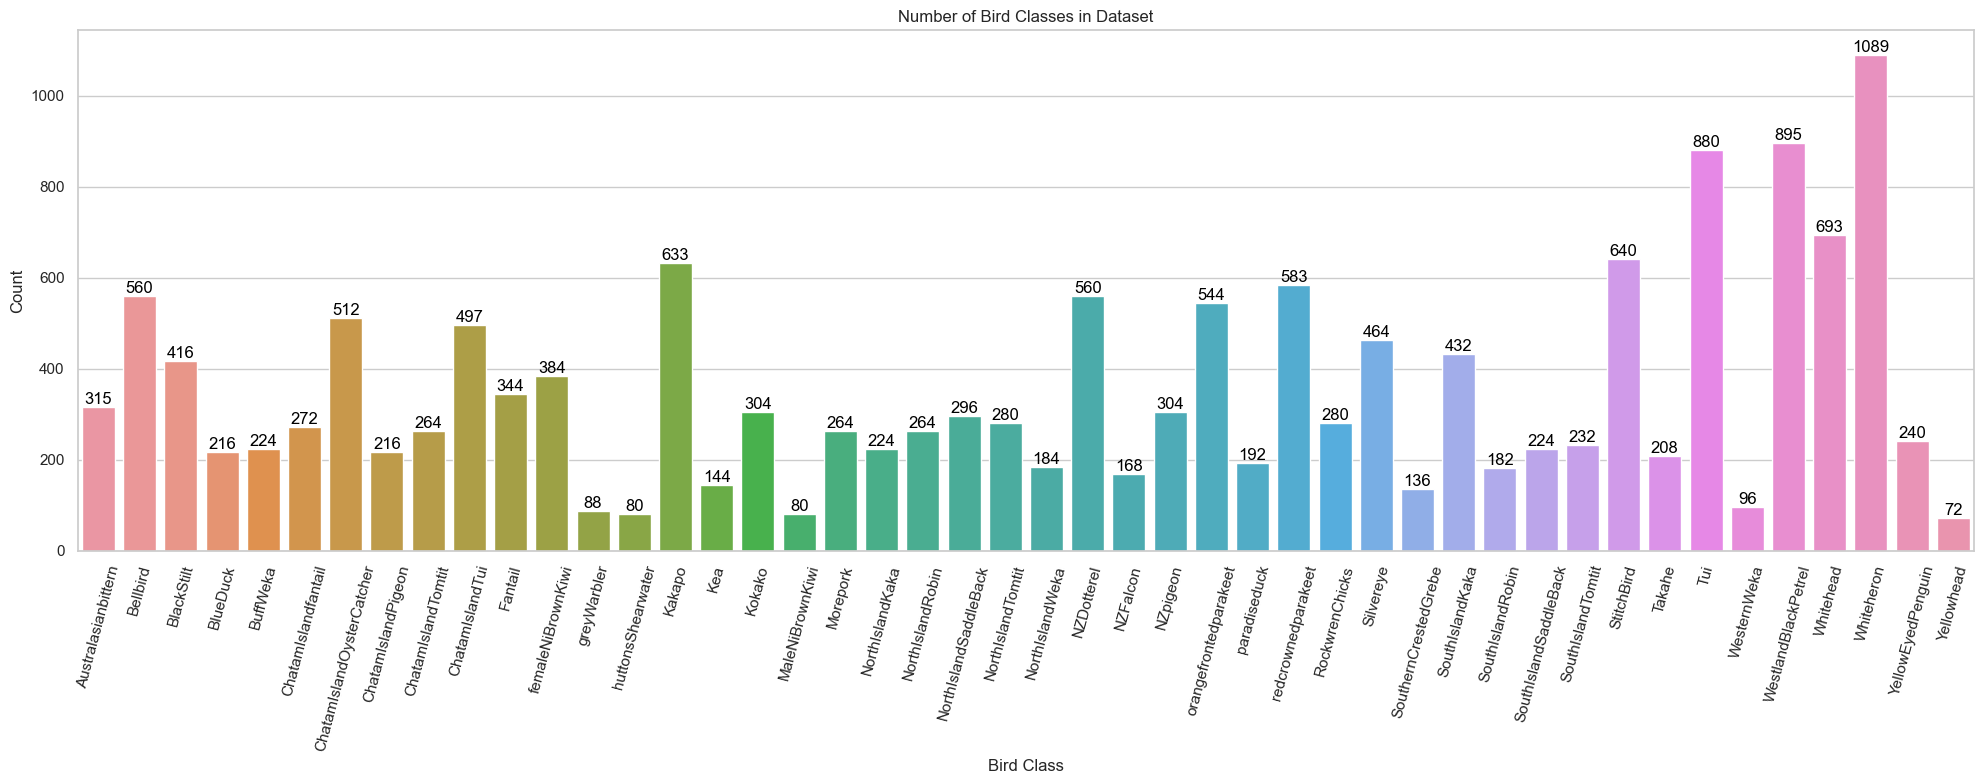

In [8]:
# counter for each bird subfolder
bird_class_counts = Counter()

# Iterate through each bird class and name
for folds in folders:
    folder_path=f'{dataset_path}/{folds}'
    wav_files=librosa.util.find_files(folder_path, ext='wav')
    bird_classes=[extract_bird_class(os.path.basename(file)) for file in wav_files]
    bird_class_counts.update(bird_classes)

plot_bird_class_counts(bird_class_counts)

In [9]:
# Statistical summary
sum_count, mean_count, max_count, min_count = calculate_statistics(bird_class_counts)

print(f"[Total]: {sum_count}")
print(f"[Mean]: {mean_count:.2f}")
print(f"[Max]: {max_count}")
print(f"[Min]: {min_count}")

[Total]: 16175
[Mean]: 351.63
[Max]: 1089
[Min]: 72


We have a highly imbalance data. The statistical analysis, we can see our average number of bird in each class is around 305 ish, 1184 for max, and 39 for min. Imblearn library is a highly popular tools to combat imbalance dataset, but will require experimenting to find the most optimal sampling strategy. These strategy involves oversampling a class, undersampling, or utilising both. 

#### We need to make sure to apply cross validation before resampling (under-sampling or up-scaling) to avoid data leakage.

- This is due to when we train a model with modified dataset, it will only introduce biasness. Applying cross validation after, ensures each training and testing folds maintain original class distribution beforehand. This will allow a more accurate representation of a model's performance.

- Dataleakage is also another problem. It risks test dataset to leak into training; skewing the performance metric. 

So for imbalance dataset, we want to analysis model performance using confusion matrix (original dataset) to see classification metric. In our case, our confusion matrix showcase this.
After, we can proceed to modify our dataset, but first we gotta extract our processed data.

## 2. Audio Preprocessing (Mel-Spectrogram)

In [10]:
# Loop through each folder to check audio quality

# Set path directory
folds = os.listdir(dataset_path)

# Loop through each fold
for fold in tqdm(folds, desc='Progression'):
    folder_path = os.path.join(dataset_path, fold)
    wav_files = librosa.util.find_files(folder_path, ext='wav')
    
    # Loop through each wav file in the folder
    for wav_file in wav_files:
        y, sr = librosa.load(wav_file, sr=None)
        print(f"Sample rate for {wav_file}: {sr} Hz")

Progression:   0%|                                                                              | 0/46 [00:00<?, ?it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.01.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.02.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.03.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.04.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.05.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.06.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.07.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.08.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.09.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.10.wav: 48000 Hz
Sample rat

Progression:   2%|█▌                                                                    | 1/46 [00:03<02:33,  3.40s/it]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.58.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.59.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.60.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.61.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.62.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.63.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.64.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.65.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.66.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.67.wav: 22050 Hz
Sample rat

Progression:   4%|███                                                                   | 2/46 [00:03<01:10,  1.60s/it]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold10\ChatamIslandTui.444.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold10\ChatamIslandTui.445.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold10\ChatamIslandTui.446.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold10\ChatamIslandTui.447.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold10\ChatamIslandTui.448.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold10\ChatamIslandTui.449.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold10\ChatamIslandTui.45.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold10\ChatamIslandTui.450.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold10\ChatamIslandTui.451.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold10\ChatamIslandTui.452.wav: 22050 Hz
Sample rate for C:\Users\ssr280

Progression:   7%|████▌                                                                 | 3/46 [00:03<00:41,  1.03it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold11\Fantail.277.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold11\Fantail.278.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold11\Fantail.279.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold11\Fantail.28.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold11\Fantail.280.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold11\Fantail.281.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold11\Fantail.282.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold11\Fantail.283.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold11\Fantail.284.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold11\Fantail.285.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold11\Fantail.286.wav: 22050 Hz
Sample rate for C:\Use

Progression:   9%|██████                                                                | 4/46 [00:04<00:28,  1.46it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold12\femaleNiBrownKiwi.255.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold12\femaleNiBrownKiwi.256.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold12\femaleNiBrownKiwi.257.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold12\femaleNiBrownKiwi.258.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold12\femaleNiBrownKiwi.259.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold12\femaleNiBrownKiwi.26.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold12\femaleNiBrownKiwi.260.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold12\femaleNiBrownKiwi.261.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold12\femaleNiBrownKiwi.262.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold12\femaleNiBrownKiwi.263.wav: 22050 Hz
Sample rate

Progression:  13%|█████████▏                                                            | 6/46 [00:04<00:14,  2.84it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold14\huttonsShearwater.09.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold14\huttonsShearwater.10.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold14\huttonsShearwater.11.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold14\huttonsShearwater.12.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold14\huttonsShearwater.13.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold14\huttonsShearwater.14.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold14\huttonsShearwater.15.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold14\huttonsShearwater.16.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold14\huttonsShearwater.17.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold14\huttonsShearwater.18.wav: 22050 Hz
Sample rate for C:\U

Progression:  15%|██████████▋                                                           | 7/46 [00:04<00:14,  2.72it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold15\Kakapo.79.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold15\Kakapo.80(1).wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold15\Kakapo.80.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold15\Kakapo.81.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold15\Kakapo.82.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold15\Kakapo.83.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold15\Kakapo.84.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold15\Kakapo.85.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold15\Kakapo.86.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold15\Kakapo.87.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold15\Kakapo.88.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\da

Progression:  17%|████████████▏                                                         | 8/46 [00:05<00:14,  2.60it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold16\Kea.93.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold16\Kea.94.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold16\Kea.95.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold16\Kea.96.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold16\Kea.97.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold16\Kea.98.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold16\Kea.99.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold17\Kokako.01.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold17\Kokako.02.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold17\Kokako.03.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold17\Kokako.04.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold17\K

Progression:  20%|█████████████▋                                                        | 9/46 [00:06<00:24,  1.51it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold17\Kokako.59.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold17\Kokako.60.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold17\Kokako.61.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold17\Kokako.62.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold17\Kokako.63.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold17\Kokako.64.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold17\Kokako.65.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold17\Kokako.66.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold17\Kokako.67.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold17\Kokako.68.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold17\Kokako.69.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_

Progression:  22%|███████████████                                                      | 10/46 [00:06<00:21,  1.71it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold18\MaleNiBrownKiwi.49.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold18\MaleNiBrownKiwi.50.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold18\MaleNiBrownKiwi.51.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold18\MaleNiBrownKiwi.52.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold18\MaleNiBrownKiwi.53.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold18\MaleNiBrownKiwi.54.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold18\MaleNiBrownKiwi.55.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold18\MaleNiBrownKiwi.56.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold18\MaleNiBrownKiwi.57.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold18\MaleNiBrownKiwi.58.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\da

Progression:  24%|████████████████▌                                                    | 11/46 [00:08<00:26,  1.30it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold19\Morepork.77.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold19\Morepork.78.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold19\Morepork.79.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold19\Morepork.80.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold19\Morepork.81.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold19\Morepork.82.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold19\Morepork.83.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold19\Morepork.84.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold19\Morepork.85.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold19\Morepork.86.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold19\Morepork.87.wav: 22050 Hz
Sample rate for C:\Us

Progression:  26%|██████████████████                                                   | 12/46 [00:10<00:43,  1.29s/it]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold2\Bellbird.75.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold2\Bellbird.76.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold2\Bellbird.77.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold2\Bellbird.78.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold2\Bellbird.79.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold2\Bellbird.80.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold2\Bellbird.81.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold2\Bellbird.82.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold2\Bellbird.83.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold2\Bellbird.84.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold2\Bellbird.85.wav: 22050 Hz
Sample rate for C:\Users\ssr2801

Progression:  28%|███████████████████▌                                                 | 13/46 [00:11<00:40,  1.21s/it]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold20\NorthIslandKaka.73.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold20\NorthIslandKaka.74.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold20\NorthIslandKaka.75.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold20\NorthIslandKaka.76.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold20\NorthIslandKaka.77.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold20\NorthIslandKaka.78.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold20\NorthIslandKaka.79.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold20\NorthIslandKaka.80.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold20\NorthIslandKaka.81.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold20\NorthIslandKaka.82.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\da

Progression:  30%|█████████████████████                                                | 14/46 [00:12<00:38,  1.21s/it]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold21\NorthIslandRobin.85.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold21\NorthIslandRobin.86.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold21\NorthIslandRobin.87.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold21\NorthIslandRobin.88.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold21\NorthIslandRobin.89.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold21\NorthIslandRobin.90.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold21\NorthIslandRobin.91.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold21\NorthIslandRobin.92.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold21\NorthIslandRobin.93.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold21\NorthIslandRobin.94.wav: 22050 Hz
Sample rate for C:\Users\ssr28

Progression:  33%|██████████████████████▌                                              | 15/46 [00:14<00:39,  1.26s/it]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold22\NorthIslandSaddleBack.55.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold22\NorthIslandSaddleBack.56.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold22\NorthIslandSaddleBack.57.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold22\NorthIslandSaddleBack.58.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold22\NorthIslandSaddleBack.59.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold22\NorthIslandSaddleBack.60.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold22\NorthIslandSaddleBack.61.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold22\NorthIslandSaddleBack.62.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold22\NorthIslandSaddleBack.63.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold22\NorthIslandSaddleBa

Progression:  35%|████████████████████████                                             | 16/46 [00:15<00:38,  1.27s/it]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold23\NorthIslandTomtit.86.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold23\NorthIslandTomtit.87.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold23\NorthIslandTomtit.88.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold23\NorthIslandTomtit.89.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold23\NorthIslandTomtit.90.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold23\NorthIslandTomtit.91.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold23\NorthIslandTomtit.92.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold23\NorthIslandTomtit.93.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold23\NorthIslandTomtit.94.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold23\NorthIslandTomtit.95.wav: 22050 Hz
Sample rate for C:\U

Progression:  37%|█████████████████████████▌                                           | 17/46 [00:16<00:33,  1.14s/it]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold24\NorthIslandWeka.79.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold24\NorthIslandWeka.80.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold24\NorthIslandWeka.81.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold24\NorthIslandWeka.82.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold24\NorthIslandWeka.83.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold24\NorthIslandWeka.84.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold24\NorthIslandWeka.85.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold24\NorthIslandWeka.86.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold24\NorthIslandWeka.87.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold24\NorthIslandWeka.88.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\da

Progression:  39%|███████████████████████████                                          | 18/46 [00:19<00:44,  1.59s/it]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold25\NZDotterel.62.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold25\NZDotterel.63.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold25\NZDotterel.64.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold25\NZDotterel.65.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold25\NZDotterel.66.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold25\NZDotterel.67.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold25\NZDotterel.68.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold25\NZDotterel.69.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold25\NZDotterel.70.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold25\NZDotterel.71.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold25\NZDotterel.72.wav: 22050 Hz

Progression:  41%|████████████████████████████▌                                        | 19/46 [00:19<00:36,  1.36s/it]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold26\NZFalcon.67.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold26\NZFalcon.68.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold26\NZFalcon.69.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold26\NZFalcon.70.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold26\NZFalcon.71.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold26\NZFalcon.72.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold26\NZFalcon.73.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold26\NZFalcon.74.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold26\NZFalcon.75.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold26\NZFalcon.76.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold26\NZFalcon.77.wav: 22050 Hz
Sample rate for C:\Us

Progression:  43%|██████████████████████████████                                       | 20/46 [00:21<00:36,  1.40s/it]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold27\NZpigeon.72.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold27\NZpigeon.73.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold27\NZpigeon.74.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold27\NZpigeon.75.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold27\NZpigeon.76.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold27\NZpigeon.77.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold27\NZpigeon.78.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold27\NZpigeon.79.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold27\NZpigeon.80.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold27\NZpigeon.81.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold27\NZpigeon.82.wav: 22050 Hz
Sample rate for C:\Us

Progression:  46%|███████████████████████████████▍                                     | 21/46 [00:24<00:49,  2.00s/it]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold28\orangefrontedparakeet.95.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold28\orangefrontedparakeet.96.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold28\orangefrontedparakeet.97.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold28\orangefrontedparakeet.98.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold28\orangefrontedparakeet.99.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold29\paradiseduck.01.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold29\paradiseduck.02.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold29\paradiseduck.03.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold29\paradiseduck.04.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold29\paradiseduck.05.wav: 48000 Hz
Sample rate for C:\Users\

Progression:  48%|█████████████████████████████████                                    | 22/46 [00:25<00:41,  1.74s/it]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold29\paradiseduck.80.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold29\paradiseduck.81.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold29\paradiseduck.82.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold29\paradiseduck.83.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold29\paradiseduck.84.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold29\paradiseduck.85.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold29\paradiseduck.86.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold29\paradiseduck.87.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold29\paradiseduck.88.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold29\paradiseduck.89.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold29\paradis

Progression:  50%|██████████████████████████████████▌                                  | 23/46 [00:26<00:35,  1.53s/it]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold3\BlackStilt.378.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold3\BlackStilt.379.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold3\BlackStilt.38.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold3\BlackStilt.380.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold3\BlackStilt.381.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold3\BlackStilt.382.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold3\BlackStilt.383.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold3\BlackStilt.384.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold3\BlackStilt.385.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold3\BlackStilt.386.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold3\BlackStilt.387.wav: 22050 Hz


Progression:  52%|████████████████████████████████████                                 | 24/46 [00:30<00:46,  2.12s/it]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold30\redcrownedparakeet.641.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold30\redcrownedparakeet.642.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold30\redcrownedparakeet.643.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold30\redcrownedparakeet.644.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold30\redcrownedparakeet.645.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold30\redcrownedparakeet.646.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold30\redcrownedparakeet.647.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold30\redcrownedparakeet.648.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold30\redcrownedparakeet.68.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold30\redcrownedparakeet.71.wav: 48000 Hz
Sa

Progression:  54%|█████████████████████████████████████▌                               | 25/46 [00:32<00:42,  2.02s/it]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold31\RockwrenChicks.76.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold31\RockwrenChicks.77.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold31\RockwrenChicks.78.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold31\RockwrenChicks.79.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold31\RockwrenChicks.80.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold31\RockwrenChicks.81.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold31\RockwrenChicks.82.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold31\RockwrenChicks.83.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold31\RockwrenChicks.84.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold31\RockwrenChicks.85.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_cod

Progression:  57%|███████████████████████████████████████                              | 26/46 [00:35<00:45,  2.28s/it]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold32\Silvereye.91.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold32\Silvereye.92.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold32\Silvereye.93.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold32\Silvereye.94.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold32\Silvereye.95.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold32\Silvereye.96.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold32\Silvereye.97.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold32\Silvereye.98.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold32\Silvereye.99.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold33\SouthernCrestedGrebe.01.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold33\SouthernCrestedGrebe.02.wa

Progression:  59%|████████████████████████████████████████▌                            | 27/46 [00:35<00:35,  1.85s/it]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold33\SouthernCrestedGrebe.93.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold33\SouthernCrestedGrebe.94.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold33\SouthernCrestedGrebe.95.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold33\SouthernCrestedGrebe.96.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold33\SouthernCrestedGrebe.97.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold33\SouthernCrestedGrebe.98.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold33\SouthernCrestedGrebe.99.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold34\SouthIslandKaka.01.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold34\SouthIslandKaka.02.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold34\SouthIslandKaka.03.wav: 48000 Hz
Sampl

Progression:  61%|██████████████████████████████████████████                           | 28/46 [00:38<00:38,  2.15s/it]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold34\SouthIslandKaka.82.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold34\SouthIslandKaka.83.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold34\SouthIslandKaka.84.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold34\SouthIslandKaka.85.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold34\SouthIslandKaka.86.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold34\SouthIslandKaka.87.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold34\SouthIslandKaka.88.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold34\SouthIslandKaka.89.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold34\SouthIslandKaka.90.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold34\SouthIslandKaka.91.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\da

Progression:  63%|███████████████████████████████████████████▌                         | 29/46 [00:39<00:31,  1.85s/it]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold36\SouthIslandSaddleBack.01.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold36\SouthIslandSaddleBack.02.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold36\SouthIslandSaddleBack.03.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold36\SouthIslandSaddleBack.04.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold36\SouthIslandSaddleBack.05.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold36\SouthIslandSaddleBack.06.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold36\SouthIslandSaddleBack.07.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold36\SouthIslandSaddleBack.08.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold36\SouthIslandSaddleBack.09.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold36\SouthIslandSaddleBa

Progression:  65%|█████████████████████████████████████████████                        | 30/46 [00:41<00:27,  1.71s/it]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold36\SouthIslandSaddleBack.79.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold36\SouthIslandSaddleBack.80.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold36\SouthIslandSaddleBack.81.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold36\SouthIslandSaddleBack.82.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold36\SouthIslandSaddleBack.83.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold36\SouthIslandSaddleBack.84.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold36\SouthIslandSaddleBack.85.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold36\SouthIslandSaddleBack.86.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold36\SouthIslandSaddleBack.87.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold36\SouthIslandSaddleBa

Progression:  67%|██████████████████████████████████████████████▌                      | 31/46 [00:42<00:24,  1.63s/it]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold37\SouthIslandTomtit.86.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold37\SouthIslandTomtit.87.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold37\SouthIslandTomtit.88.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold37\SouthIslandTomtit.89.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold37\SouthIslandTomtit.90.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold37\SouthIslandTomtit.91.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold37\SouthIslandTomtit.92.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold37\SouthIslandTomtit.93.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold37\SouthIslandTomtit.94.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold37\SouthIslandTomtit.95.wav: 22050 Hz
Sample rate for C:\U

Progression:  70%|████████████████████████████████████████████████                     | 32/46 [00:46<00:32,  2.31s/it]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold38\StitchBird.96.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold38\StitchBird.97.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold38\StitchBird.98.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold38\StitchBird.99.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold39\Takahe.01.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold39\Takahe.02.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold39\Takahe.03.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold39\Takahe.04.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold39\Takahe.05.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold39\Takahe.06.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold39\Takahe.07.wav: 48000 Hz
Sample rate for C:\Users\ss

Progression:  72%|█████████████████████████████████████████████████▌                   | 33/46 [00:47<00:25,  1.98s/it]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold39\Takahe.67.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold39\Takahe.68.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold39\Takahe.69.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold39\Takahe.70.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold39\Takahe.71.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold39\Takahe.72.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold39\Takahe.73.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold39\Takahe.74.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold39\Takahe.75.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold39\Takahe.76.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold39\Takahe.77.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_

Progression:  74%|███████████████████████████████████████████████████                  | 34/46 [00:48<00:17,  1.43s/it]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold4\BlueDuck.134.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold4\BlueDuck.135.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold4\BlueDuck.136.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold4\BlueDuck.137.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold4\BlueDuck.138.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold4\BlueDuck.139.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold4\BlueDuck.14.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold4\BlueDuck.140.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold4\BlueDuck.141.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold4\BlueDuck.142.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold4\BlueDuck.143.wav: 22050 Hz
Sample rate for C:\Use

Progression:  76%|████████████████████████████████████████████████████▌                | 35/46 [00:53<00:28,  2.59s/it]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold40\Tui.879.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold40\Tui.88.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold40\Tui.880.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold40\Tui.89.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold40\Tui.90.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold40\Tui.91.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold40\Tui.92.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold40\Tui.93.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold40\Tui.94.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold40\Tui.95.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold40\Tui.96.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold40\Tui.97.wav:

Progression:  78%|██████████████████████████████████████████████████████               | 36/46 [00:53<00:19,  2.00s/it]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold41\WesternWeka.76.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold41\WesternWeka.77.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold41\WesternWeka.78.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold41\WesternWeka.79.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold41\WesternWeka.80.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold41\WesternWeka.81.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold41\WesternWeka.82.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold41\WesternWeka.83.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold41\WesternWeka.84.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold41\WesternWeka.85.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold41\WesternWeka.86.wa

Progression:  80%|███████████████████████████████████████████████████████▌             | 37/46 [00:58<00:26,  2.89s/it]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold42\WestlandBlackPetrel.997.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold42\WestlandBlackPetrel.998.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold42\WestlandBlackPetrel.999.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold43\Whitehead.02.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold43\Whitehead.03.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold43\Whitehead.04.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold43\Whitehead.05.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold43\Whitehead.07.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold43\Whitehead.08.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold43\Whitehead.09.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold43\Whit

Progression:  83%|█████████████████████████████████████████████████████████            | 38/46 [01:03<00:26,  3.29s/it]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold43\Whitehead.74.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold43\Whitehead.75.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold43\Whitehead.77.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold43\Whitehead.78.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold43\Whitehead.79.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold43\Whitehead.81.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold43\Whitehead.82.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold43\Whitehead.83.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold43\Whitehead.84.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold43\Whitehead.85.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold43\Whitehead.86.wav: 48000 Hz
Sample rat

Progression:  85%|██████████████████████████████████████████████████████████▌          | 39/46 [01:09<00:30,  4.34s/it]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold44\Whiteheron.988.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold44\Whiteheron.989.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold44\Whiteheron.99.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold44\Whiteheron.990.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold44\Whiteheron.991.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold44\Whiteheron.992.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold44\Whiteheron.993.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold44\Whiteheron.994.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold44\Whiteheron.995.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold44\Whiteheron.996.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold44\Whiteheron.997.wav

Progression:  87%|████████████████████████████████████████████████████████████         | 40/46 [01:11<00:20,  3.49s/it]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold45\YellowEyedPenguin.77.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold45\YellowEyedPenguin.78.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold45\YellowEyedPenguin.79.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold45\YellowEyedPenguin.80.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold45\YellowEyedPenguin.81.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold45\YellowEyedPenguin.82.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold45\YellowEyedPenguin.83.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold45\YellowEyedPenguin.84.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold45\YellowEyedPenguin.85.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold45\YellowEyedPenguin.86.wav: 22050 Hz
Sample rate for C:\U

Progression:  89%|█████████████████████████████████████████████████████████████▌       | 41/46 [01:11<00:12,  2.58s/it]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold46\Yellowhead.44.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold46\Yellowhead.45.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold46\Yellowhead.46.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold46\Yellowhead.47.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold46\Yellowhead.48.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold46\Yellowhead.49.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold46\Yellowhead.50.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold46\Yellowhead.51.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold46\Yellowhead.52.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold46\Yellowhead.53.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold46\Yellowhead.54.wav: 22050 Hz

Progression:  91%|██████████████████████████████████████████████████████████████▉      | 42/46 [01:12<00:07,  1.85s/it]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold5\BuffWeka.148.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold5\BuffWeka.149.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold5\BuffWeka.15.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold5\BuffWeka.150.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold5\BuffWeka.151.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold5\BuffWeka.152.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold5\BuffWeka.153.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold5\BuffWeka.154.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold5\BuffWeka.155.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold5\BuffWeka.156.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold5\BuffWeka.157.wav: 22050 Hz
Sample rate for C:\Use

Progression:  93%|████████████████████████████████████████████████████████████████▌    | 43/46 [01:12<00:04,  1.35s/it]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold6\ChatamIslandfantail.257.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold6\ChatamIslandfantail.258.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold6\ChatamIslandfantail.259.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold6\ChatamIslandfantail.26.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold6\ChatamIslandfantail.260.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold6\ChatamIslandfantail.261.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold6\ChatamIslandfantail.262.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold6\ChatamIslandfantail.263.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold6\ChatamIslandfantail.264.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold6\ChatamIslandfantail.265.wav: 22050 Hz
S

Progression:  96%|██████████████████████████████████████████████████████████████████   | 44/46 [01:12<00:02,  1.04s/it]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold7\ChatamIslandOysterCatcher.29.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold7\ChatamIslandOysterCatcher.290.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold7\ChatamIslandOysterCatcher.291.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold7\ChatamIslandOysterCatcher.292.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold7\ChatamIslandOysterCatcher.293.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold7\ChatamIslandOysterCatcher.294.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold7\ChatamIslandOysterCatcher.295.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold7\ChatamIslandOysterCatcher.296.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold7\ChatamIslandOysterCatcher.297.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_

Progression:  98%|███████████████████████████████████████████████████████████████████▌ | 45/46 [01:12<00:00,  1.30it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold8\ChatamIslandPigeon.10.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold8\ChatamIslandPigeon.100.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold8\ChatamIslandPigeon.101.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold8\ChatamIslandPigeon.102.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold8\ChatamIslandPigeon.103.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold8\ChatamIslandPigeon.104.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold8\ChatamIslandPigeon.105.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold8\ChatamIslandPigeon.106.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold8\ChatamIslandPigeon.107.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold8\ChatamIslandPigeon.108.wav: 22050 Hz
Sample rate

Progression: 100%|█████████████████████████████████████████████████████████████████████| 46/46 [01:12<00:00,  1.58s/it]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold9\ChatamIslandTomtit.21.wav: 48000 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold9\ChatamIslandTomtit.210.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold9\ChatamIslandTomtit.211.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold9\ChatamIslandTomtit.212.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold9\ChatamIslandTomtit.213.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold9\ChatamIslandTomtit.214.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold9\ChatamIslandTomtit.215.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold9\ChatamIslandTomtit.216.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold9\ChatamIslandTomtit.217.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold9\ChatamIslandTomtit.218.wav: 22050 Hz
Sample rate

As we can see, the sample rates are either 48000 Hz and 22050 Hz after we performed data augmentations. To allow more consistent yield, the sample rate will be loaded changed for more consistency. Tensorflow recommends sample rate of 16000 Hz, however, this sample rate does not seem to capture enough information for our audio in mel-spectrogram. Where larger sample rate only increases the computational processes and memory 22050 Hz sample rate will be used.

In [11]:
# Audio path of a sample not noise reduced
sample = r'C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.01.wav'
#sample = r'C:\Users\leeju\BirdProject\data_for_code_new\fold1\Australasianbittern.01.wav'

In [12]:
# Sample without noise reduced
ipd.Audio(sample)

In [13]:
# Loop through each folder to check audio quality

# Set path directory 
folds = os.listdir(dataset_path)

# Loop through each fold
for fold in tqdm(folds, desc='Progression'):
    folder_path = os.path.join(dataset_path, fold)
    wav_files = librosa.util.find_files(folder_path, ext='wav')
    
    # Loop through each wav file in the folder
    for wav_file in wav_files:
        y, sr = librosa.load(wav_file, sr=22050)
        print(f"Sample rate for {wav_file}: {sr} Hz")

Progression:   0%|                                                                              | 0/46 [00:00<?, ?it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.01.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.02.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.03.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.04.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.05.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.06.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.07.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.08.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.09.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.10.wav: 22050 Hz
Sample rat

Progression:   2%|█▌                                                                    | 1/46 [00:00<00:12,  3.70it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.28.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.280.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.281.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.282.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.283.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.284.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.285.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.286.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.287.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.288.wav: 22050 Hz
S

Progression:   4%|███                                                                   | 2/46 [00:00<00:15,  2.82it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold10\ChatamIslandTui.51.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold10\ChatamIslandTui.52.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold10\ChatamIslandTui.53.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold10\ChatamIslandTui.54.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold10\ChatamIslandTui.55.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold10\ChatamIslandTui.56.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold10\ChatamIslandTui.57.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold10\ChatamIslandTui.58.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold10\ChatamIslandTui.59.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold10\ChatamIslandTui.60.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\da

Progression:   7%|████▌                                                                 | 3/46 [00:00<00:13,  3.17it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold11\Fantail.24.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold11\Fantail.240.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold11\Fantail.241.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold11\Fantail.242.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold11\Fantail.243.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold11\Fantail.244.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold11\Fantail.245.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold11\Fantail.246.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold11\Fantail.247.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold11\Fantail.248.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold11\Fantail.249.wav: 22050 Hz
Sample rate for C:\Use

Progression:  13%|█████████▏                                                            | 6/46 [00:01<00:07,  5.42it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold12\femaleNiBrownKiwi.42.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold12\femaleNiBrownKiwi.43.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold12\femaleNiBrownKiwi.44.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold12\femaleNiBrownKiwi.45.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold12\femaleNiBrownKiwi.46.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold12\femaleNiBrownKiwi.47.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold12\femaleNiBrownKiwi.48.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold12\femaleNiBrownKiwi.49.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold12\femaleNiBrownKiwi.50.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold12\femaleNiBrownKiwi.51.wav: 22050 Hz
Sample rate for C:\U

Progression:  15%|██████████▋                                                           | 7/46 [00:01<00:10,  3.63it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold15\Kakapo.59.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold15\Kakapo.590.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold15\Kakapo.591.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold15\Kakapo.592.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold15\Kakapo.593.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold15\Kakapo.594.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold15\Kakapo.595.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold15\Kakapo.596.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold15\Kakapo.597.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold15\Kakapo.598.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold15\Kakapo.599.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\

Progression:  17%|████████████▏                                                         | 8/46 [00:02<00:08,  4.26it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold16\Kea.32.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold16\Kea.33.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold16\Kea.34.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold16\Kea.35.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold16\Kea.36.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold16\Kea.37.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold16\Kea.38.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold16\Kea.39.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold16\Kea.40.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold16\Kea.41.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold16\Kea.42.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold16\Kea.43.wav: 2

Progression:  20%|█████████████▋                                                        | 9/46 [00:02<00:08,  4.20it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold17\Kokako.31.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold17\Kokako.32.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold17\Kokako.33.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold17\Kokako.34.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold17\Kokako.35.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold17\Kokako.36.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold17\Kokako.37.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold17\Kokako.38.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold17\Kokako.39.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold17\Kokako.40.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold17\Kokako.41.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_

Progression:  24%|████████████████▌                                                    | 11/46 [00:02<00:06,  5.18it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold19\Morepork.19.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold19\Morepork.190.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold19\Morepork.191.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold19\Morepork.192.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold19\Morepork.193.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold19\Morepork.194.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold19\Morepork.195.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold19\Morepork.196.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold19\Morepork.197.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold19\Morepork.198.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold19\Morepork.199.wav: 22050 Hz
Sample rate

Progression:  26%|██████████████████                                                   | 12/46 [00:03<00:08,  3.96it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold2\Bellbird.465.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold2\Bellbird.466.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold2\Bellbird.467.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold2\Bellbird.468.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold2\Bellbird.469.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold2\Bellbird.47.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold2\Bellbird.470.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold2\Bellbird.471.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold2\Bellbird.472.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold2\Bellbird.473.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold2\Bellbird.474.wav: 22050 Hz
Sample rate for C:\Use

Progression:  28%|███████████████████▌                                                 | 13/46 [00:03<00:07,  4.24it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold20\NorthIslandKaka.14.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold20\NorthIslandKaka.140.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold20\NorthIslandKaka.141.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold20\NorthIslandKaka.142.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold20\NorthIslandKaka.143.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold20\NorthIslandKaka.144.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold20\NorthIslandKaka.145.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold20\NorthIslandKaka.146.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold20\NorthIslandKaka.147.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold20\NorthIslandKaka.148.wav: 22050 Hz
Sample rate for C:\Users\ssr280

Progression:  30%|█████████████████████                                                | 14/46 [00:03<00:07,  4.40it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold21\NorthIslandRobin.191.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold21\NorthIslandRobin.192.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold21\NorthIslandRobin.193.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold21\NorthIslandRobin.194.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold21\NorthIslandRobin.195.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold21\NorthIslandRobin.196.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold21\NorthIslandRobin.197.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold21\NorthIslandRobin.198.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold21\NorthIslandRobin.199.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold21\NorthIslandRobin.20.wav: 22050 Hz
Sample rate for C:\Us

Progression:  33%|██████████████████████▌                                              | 15/46 [00:03<00:07,  4.29it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold22\NorthIslandSaddleBack.20.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold22\NorthIslandSaddleBack.200.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold22\NorthIslandSaddleBack.201.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold22\NorthIslandSaddleBack.202.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold22\NorthIslandSaddleBack.203.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold22\NorthIslandSaddleBack.204.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold22\NorthIslandSaddleBack.205.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold22\NorthIslandSaddleBack.206.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold22\NorthIslandSaddleBack.207.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold22\NorthIsland

Progression:  35%|████████████████████████                                             | 16/46 [00:03<00:06,  4.36it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold23\NorthIslandTomtit.18.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold23\NorthIslandTomtit.180.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold23\NorthIslandTomtit.181.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold23\NorthIslandTomtit.182.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold23\NorthIslandTomtit.183.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold23\NorthIslandTomtit.184.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold23\NorthIslandTomtit.185.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold23\NorthIslandTomtit.186.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold23\NorthIslandTomtit.187.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold23\NorthIslandTomtit.188.wav: 22050 Hz
Sample rate

Progression:  37%|█████████████████████████▌                                           | 17/46 [00:04<00:06,  4.79it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold24\NorthIslandWeka.156.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold24\NorthIslandWeka.157.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold24\NorthIslandWeka.158.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold24\NorthIslandWeka.159.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold24\NorthIslandWeka.16.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold24\NorthIslandWeka.160.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold24\NorthIslandWeka.161.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold24\NorthIslandWeka.162.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold24\NorthIslandWeka.163.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold24\NorthIslandWeka.164.wav: 22050 Hz
Sample rate for C:\Users\ssr280

Progression:  39%|███████████████████████████                                          | 18/46 [00:04<00:07,  3.58it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold25\NZDotterel.484.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold25\NZDotterel.485.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold25\NZDotterel.486.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold25\NZDotterel.487.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold25\NZDotterel.488.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold25\NZDotterel.489.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold25\NZDotterel.49.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold25\NZDotterel.490.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold25\NZDotterel.491.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold25\NZDotterel.492.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold25\NZDotterel.493.wav

Progression:  41%|████████████████████████████▌                                        | 19/46 [00:04<00:06,  4.11it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold26\NZFalcon.149.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold26\NZFalcon.15.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold26\NZFalcon.150.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold26\NZFalcon.151.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold26\NZFalcon.152.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold26\NZFalcon.153.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold26\NZFalcon.154.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold26\NZFalcon.155.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold26\NZFalcon.156.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold26\NZFalcon.157.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold26\NZFalcon.158.wav: 22050 Hz
Sample rate

Progression:  43%|██████████████████████████████                                       | 20/46 [00:04<00:06,  4.07it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold27\NZpigeon.238.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold27\NZpigeon.239.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold27\NZpigeon.24.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold27\NZpigeon.240.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold27\NZpigeon.241.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold27\NZpigeon.242.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold27\NZpigeon.243.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold27\NZpigeon.244.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold27\NZpigeon.245.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold27\NZpigeon.246.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold27\NZpigeon.247.wav: 22050 Hz
Sample rate

Progression:  46%|███████████████████████████████▍                                     | 21/46 [00:05<00:07,  3.27it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold28\orangefrontedparakeet.423.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold28\orangefrontedparakeet.424.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold28\orangefrontedparakeet.425.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold28\orangefrontedparakeet.426.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold28\orangefrontedparakeet.427.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold28\orangefrontedparakeet.428.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold28\orangefrontedparakeet.429.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold28\orangefrontedparakeet.43.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold28\orangefrontedparakeet.430.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold28\orangefront

Progression:  48%|█████████████████████████████████                                    | 22/46 [00:05<00:06,  3.88it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold29\paradiseduck.129.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold29\paradiseduck.13.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold29\paradiseduck.130.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold29\paradiseduck.131.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold29\paradiseduck.132.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold29\paradiseduck.133.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold29\paradiseduck.134.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold29\paradiseduck.135.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold29\paradiseduck.136.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold29\paradiseduck.137.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold2

Progression:  50%|██████████████████████████████████▌                                  | 23/46 [00:05<00:06,  3.53it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold3\BlackStilt.49.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold3\BlackStilt.50.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold3\BlackStilt.51.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold3\BlackStilt.52.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold3\BlackStilt.53.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold3\BlackStilt.54.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold3\BlackStilt.55.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold3\BlackStilt.56.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold3\BlackStilt.57.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold3\BlackStilt.58.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold3\BlackStilt.59.wav: 22050 Hz
Sample rat

Progression:  52%|████████████████████████████████████                                 | 24/46 [00:06<00:06,  3.43it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold30\redcrownedparakeet.419.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold30\redcrownedparakeet.42.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold30\redcrownedparakeet.420.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold30\redcrownedparakeet.421.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold30\redcrownedparakeet.422.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold30\redcrownedparakeet.423.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold30\redcrownedparakeet.424.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold30\redcrownedparakeet.425.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold30\redcrownedparakeet.426.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold30\redcrownedparakeet.427.wav: 22050 Hz
S

Progression:  54%|█████████████████████████████████████▌                               | 25/46 [00:06<00:05,  3.67it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold31\RockwrenChicks.146.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold31\RockwrenChicks.147.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold31\RockwrenChicks.148.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold31\RockwrenChicks.149.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold31\RockwrenChicks.15.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold31\RockwrenChicks.150.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold31\RockwrenChicks.151.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold31\RockwrenChicks.152.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold31\RockwrenChicks.153.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold31\RockwrenChicks.154.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\dat

Progression:  57%|███████████████████████████████████████                              | 26/46 [00:06<00:06,  3.33it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold32\Silvereye.37.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold32\Silvereye.370.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold32\Silvereye.371.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold32\Silvereye.372.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold32\Silvereye.373.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold32\Silvereye.374.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold32\Silvereye.375.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold32\Silvereye.376.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold32\Silvereye.377.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold32\Silvereye.378.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold32\Silvereye.379.wav: 22050 Hz


Progression:  59%|████████████████████████████████████████▌                            | 27/46 [00:06<00:04,  4.06it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold33\SouthernCrestedGrebe.15.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold33\SouthernCrestedGrebe.16.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold33\SouthernCrestedGrebe.17.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold33\SouthernCrestedGrebe.18.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold33\SouthernCrestedGrebe.19.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold33\SouthernCrestedGrebe.20.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold33\SouthernCrestedGrebe.21.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold33\SouthernCrestedGrebe.22.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold33\SouthernCrestedGrebe.23.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold33\SouthernCrestedGrebe.24.wav:

Progression:  61%|██████████████████████████████████████████                           | 28/46 [00:07<00:04,  3.62it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold34\SouthIslandKaka.26.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold34\SouthIslandKaka.260.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold34\SouthIslandKaka.261.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold34\SouthIslandKaka.262.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold34\SouthIslandKaka.263.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold34\SouthIslandKaka.264.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold34\SouthIslandKaka.265.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold34\SouthIslandKaka.266.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold34\SouthIslandKaka.267.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold34\SouthIslandKaka.268.wav: 22050 Hz
Sample rate for C:\Users\ssr280

Progression:  63%|███████████████████████████████████████████▌                         | 29/46 [00:07<00:04,  4.23it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold35\SouthIslandRobin.01.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold35\SouthIslandRobin.02.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold35\SouthIslandRobin.03.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold35\SouthIslandRobin.04.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold35\SouthIslandRobin.05.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold35\SouthIslandRobin.06.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold35\SouthIslandRobin.07.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold35\SouthIslandRobin.08.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold35\SouthIslandRobin.09.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold35\SouthIslandRobin.10.wav: 22050 Hz
Sample rate for C:\Users\ssr28

Progression:  65%|█████████████████████████████████████████████                        | 30/46 [00:07<00:03,  4.51it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold36\SouthIslandSaddleBack.12.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold36\SouthIslandSaddleBack.120.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold36\SouthIslandSaddleBack.121.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold36\SouthIslandSaddleBack.122.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold36\SouthIslandSaddleBack.123.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold36\SouthIslandSaddleBack.124.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold36\SouthIslandSaddleBack.125.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold36\SouthIslandSaddleBack.126.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold36\SouthIslandSaddleBack.127.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold36\SouthIsland

Progression:  67%|██████████████████████████████████████████████▌                      | 31/46 [00:07<00:03,  4.77it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold37\SouthIslandTomtit.16.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold37\SouthIslandTomtit.160.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold37\SouthIslandTomtit.161.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold37\SouthIslandTomtit.162.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold37\SouthIslandTomtit.163.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold37\SouthIslandTomtit.164.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold37\SouthIslandTomtit.165.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold37\SouthIslandTomtit.166.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold37\SouthIslandTomtit.167.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold37\SouthIslandTomtit.168.wav: 22050 Hz
Sample rate

Progression:  72%|█████████████████████████████████████████████████▌                   | 33/46 [00:08<00:03,  3.81it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold38\StitchBird.80.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold38\StitchBird.81.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold38\StitchBird.82.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold38\StitchBird.83.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold38\StitchBird.84.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold38\StitchBird.85.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold38\StitchBird.86.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold38\StitchBird.87.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold38\StitchBird.88.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold38\StitchBird.89.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold38\StitchBird.90.wav: 22050 Hz

Progression:  74%|███████████████████████████████████████████████████                  | 34/46 [00:08<00:02,  4.31it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold4\BlueDuck.01.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold4\BlueDuck.02.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold4\BlueDuck.03.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold4\BlueDuck.04.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold4\BlueDuck.05.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold4\BlueDuck.06.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold4\BlueDuck.07.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold4\BlueDuck.08.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold4\BlueDuck.09.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold4\BlueDuck.10.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold4\BlueDuck.100.wav: 22050 Hz
Sample rate for C:\Users\ssr280

Progression:  76%|████████████████████████████████████████████████████▌                | 35/46 [00:09<00:04,  2.67it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold40\Tui.90.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold40\Tui.91.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold40\Tui.92.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold40\Tui.93.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold40\Tui.94.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold40\Tui.95.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold40\Tui.96.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold40\Tui.97.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold40\Tui.98.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold40\Tui.99.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold41\WesternWeka.01.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold41\Weste

Progression:  80%|███████████████████████████████████████████████████████▌             | 37/46 [00:09<00:02,  3.14it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold42\WestlandBlackPetrel.798.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold42\WestlandBlackPetrel.799.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold42\WestlandBlackPetrel.800.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold42\WestlandBlackPetrel.801.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold42\WestlandBlackPetrel.802.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold42\WestlandBlackPetrel.803.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold42\WestlandBlackPetrel.804.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold42\WestlandBlackPetrel.805.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold42\WestlandBlackPetrel.806.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold42\WestlandBlackPetrel.807.wav:

Progression:  83%|█████████████████████████████████████████████████████████            | 38/46 [00:10<00:02,  2.77it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold43\Whitehead.51.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold43\Whitehead.510.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold43\Whitehead.511.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold43\Whitehead.512.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold43\Whitehead.513.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold43\Whitehead.514.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold43\Whitehead.515.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold43\Whitehead.516.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold43\Whitehead.517.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold43\Whitehead.518.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold43\Whitehead.519.wav: 22050 Hz


Progression:  85%|██████████████████████████████████████████████████████████▌          | 39/46 [00:11<00:03,  1.95it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold44\Whiteheron.92.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold44\Whiteheron.920.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold44\Whiteheron.921.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold44\Whiteheron.922.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold44\Whiteheron.923.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold44\Whiteheron.924.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold44\Whiteheron.925.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold44\Whiteheron.926.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold44\Whiteheron.927.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold44\Whiteheron.928.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold44\Whiteheron.929.wav

Progression:  87%|████████████████████████████████████████████████████████████         | 40/46 [00:11<00:02,  2.29it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold45\YellowEyedPenguin.287.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold45\YellowEyedPenguin.288.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold45\YellowEyedPenguin.29.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold45\YellowEyedPenguin.293.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold45\YellowEyedPenguin.294.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold45\YellowEyedPenguin.296.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold45\YellowEyedPenguin.30.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold45\YellowEyedPenguin.300.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold45\YellowEyedPenguin.301.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold45\YellowEyedPenguin.305.wav: 22050 Hz
Sample rate 

Progression:  91%|██████████████████████████████████████████████████████████████▉      | 42/46 [00:11<00:01,  3.37it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold5\BuffWeka.104.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold5\BuffWeka.105.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold5\BuffWeka.106.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold5\BuffWeka.107.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold5\BuffWeka.108.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold5\BuffWeka.109.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold5\BuffWeka.11.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold5\BuffWeka.110.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold5\BuffWeka.111.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold5\BuffWeka.112.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold5\BuffWeka.113.wav: 22050 Hz
Sample rate for C:\Use

Progression:  93%|████████████████████████████████████████████████████████████████▌    | 43/46 [00:11<00:00,  3.60it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold6\ChatamIslandfantail.14.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold6\ChatamIslandfantail.140.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold6\ChatamIslandfantail.141.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold6\ChatamIslandfantail.142.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold6\ChatamIslandfantail.143.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold6\ChatamIslandfantail.144.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold6\ChatamIslandfantail.145.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold6\ChatamIslandfantail.146.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold6\ChatamIslandfantail.147.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold6\ChatamIslandfantail.148.wav: 22050 Hz
S

Progression:  96%|██████████████████████████████████████████████████████████████████   | 44/46 [00:12<00:00,  3.22it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold7\ChatamIslandOysterCatcher.411.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold7\ChatamIslandOysterCatcher.412.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold7\ChatamIslandOysterCatcher.413.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold7\ChatamIslandOysterCatcher.414.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold7\ChatamIslandOysterCatcher.415.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold7\ChatamIslandOysterCatcher.416.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold7\ChatamIslandOysterCatcher.417.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold7\ChatamIslandOysterCatcher.418.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold7\ChatamIslandOysterCatcher.419.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for

Progression:  98%|███████████████████████████████████████████████████████████████████▌ | 45/46 [00:12<00:00,  3.62it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold8\ChatamIslandPigeon.142.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold8\ChatamIslandPigeon.143.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold8\ChatamIslandPigeon.144.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold8\ChatamIslandPigeon.145.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold8\ChatamIslandPigeon.146.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold8\ChatamIslandPigeon.147.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold8\ChatamIslandPigeon.148.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold8\ChatamIslandPigeon.149.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold8\ChatamIslandPigeon.15.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold8\ChatamIslandPigeon.150.wav: 22050 Hz
Sample rate

Progression: 100%|█████████████████████████████████████████████████████████████████████| 46/46 [00:12<00:00,  3.63it/s]

Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold9\ChatamIslandTomtit.189.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold9\ChatamIslandTomtit.19.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold9\ChatamIslandTomtit.190.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold9\ChatamIslandTomtit.191.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold9\ChatamIslandTomtit.192.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold9\ChatamIslandTomtit.193.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold9\ChatamIslandTomtit.194.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold9\ChatamIslandTomtit.195.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold9\ChatamIslandTomtit.196.wav: 22050 Hz
Sample rate for C:\Users\ssr2801\Bird\data_for_code_new\fold9\ChatamIslandTomtit.197.wav: 22050 Hz
Sample rate

In [14]:
# Validate sample rate of 22050
print(sr)

22050


In [15]:
# Check number of audio samples in audio signal
y.shape

(66150,)

In [16]:
# Double check audio's length in seconds
66150/sr

3.0

## 2.1. Noise reduction On Audio

There are some audios that have background noises of other birds. One prominent example is for the Australalsian Bitten audio clips. This specific bird species have a distinct low frequency call which is compromised by high pitch of other birds in the background. To tackle this problem, a python library noisereduce will be used. First we work with a spectrogram first on the audios and then convert the reduced audio into a seperate folder.


### Stationary Noise Reduction Algorithm:

- A spectrogram is calculated over the noise audio clip
- Statistics are calculated over spectrogram of the the noise (in frequency)
- A threshold is calculated based upon the statistics of the noise (and the desired sensitivity of the algorithm)
- A spectrogram is calculated over the signal
- A mask is determined by comparing the signal spectrogram to the threshold
- The mask is smoothed with a filter over frequency and time
- The mask is appled to the spectrogram of the signal, and is inverted If the noise signal is not provided, the algorithm will treat the signal as the noise clip, which tends to work pretty well

### Non-Stationary Noise Reduction Algorithm:

- A spectrogram is calculated over the signal
- A time-smoothed version of the spectrogram is computed using an IIR filter aplied forward and backward on each frequency channel.
- A mask is computed based on that time-smoothed spectrogram
- The mask is smoothed with a filter over frequency and time
- The mask is appled to the spectrogram of the signal, and is inverted


We are performing noise reduction to further the diversity of data to feed our model. This will allow our model to handle noisy and clean data which will hopefully generalise better for performance.

In [17]:
# Declare audio path of 2 samples
austra_sample = r'C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.01.wav'
#austra_sample = r'C:\Users\leeju\BirdProject\data_for_code_new\fold1\Australasianbittern.01.wav'

In [18]:
# Load audio signals using librosa
austrabittern1, sr = librosa.load(austra_sample, sr=sr)

In [19]:
# Apply stationary noise reduction (calculates each frequency channel for noise gate). We use stationary here because we cannot predict when unwanted audio will be present 
reduced_noise = nr.reduce_noise(y=austrabittern1, sr=sr, n_fft=2048, hop_length=512, thresh_n_mult_nonstationary=5, stationary=False)

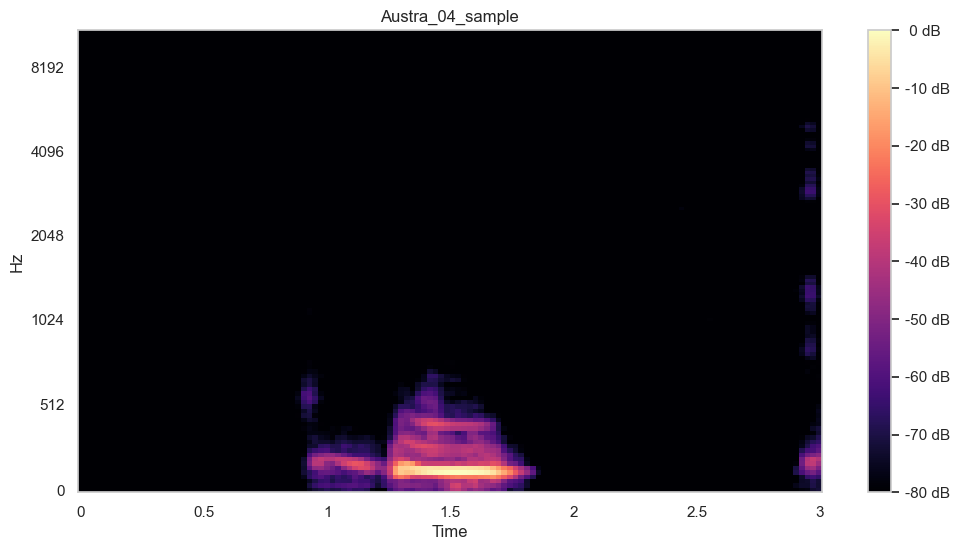

In [20]:
# Hear sample audio and plot mel-spectrogram

sample = librosa.feature.melspectrogram(y=reduced_noise, 
                                       sr=sr, 
                                       n_fft=2048, 
                                       hop_length=512, 
                                       n_mels=128)
# mel_spectrogram is taken in by M_db
M_db = librosa.power_to_db(sample, ref=np.max)
plt.figure(figsize=(12,6)) # Image display only
image = librosa.display.specshow(M_db,        
                                 x_axis='time',
                                 y_axis='mel', 
                                 sr=sr)
plt.title("Austra_04_sample")
plt.colorbar(image, format="%2.f dB")
ipd.Audio(data=reduced_noise, rate=sr)

- ### Some What Clean Target Bird Audio
```

```

Minimal background noise and solid capture of target bird

In [21]:
# Same to previous sample
#background_bird = r'C:\Users\leeju\BirdProject\data_for_code_new\fold1\Australasianbittern.05.wav'
background_bird = r'C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.05.wav'

In [22]:
background_bird, sr = librosa.load(background_bird, sr=sr)

In [23]:
unwbird_noise = nr.reduce_noise(y=background_bird, sr=sr, n_fft=2048, hop_length=512, thresh_n_mult_nonstationary=6, stationary=False) 

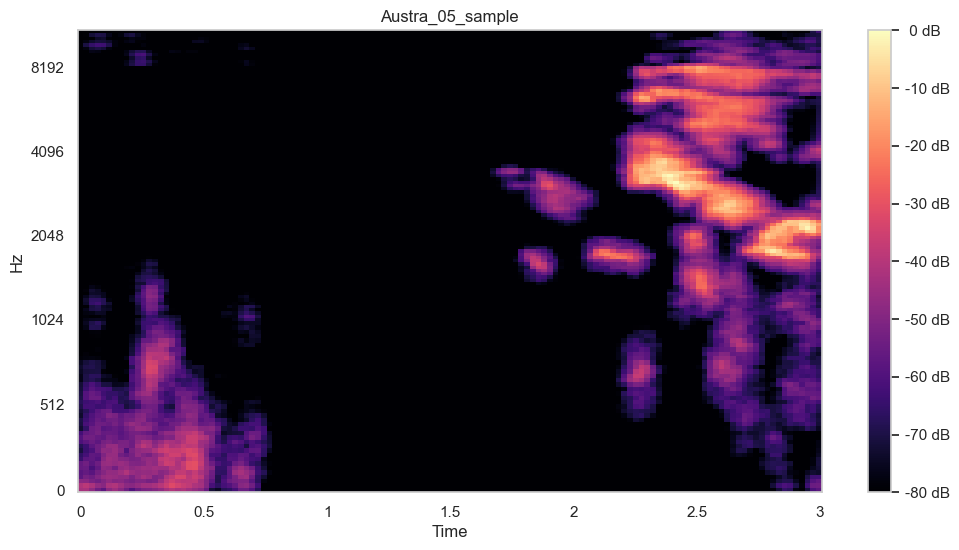

In [24]:
# In this example, the background bird is being captured instead of the targed bird
sample2 = librosa.feature.melspectrogram(y=unwbird_noise, 
                                       sr=sr, 
                                       n_fft=2048, 
                                       hop_length=512, 
                                       n_mels=128)
# mel_spectrogram is taken in by M_db
M_db2 = librosa.power_to_db(sample2, ref=np.max)
plt.figure(figsize=(12,6)) # Image display only
image2 = librosa.display.specshow(M_db2,        
                                 x_axis='time',
                                 y_axis='mel', 
                                 sr=sr)
plt.title("Austra_05_sample")
plt.colorbar(image2, format="%2.f dB")
ipd.Audio(data=unwbird_noise, rate=sr)

- ### With ONLY background bird
```

```

Here the two audio clips show with targeted bird noise and without + unwanted background noise. A noise profile to remove this unwanted audio will be performed on an audio clip that contains both wanted and unwanted noise. Now I will attempt to remove the intended noise that contains the target bird noise.

In [25]:
# Set directory for want + unwant noise
#austra_want_unwant = r'C:\Users\leeju\BirdProject\data_for_code_new\fold1\Australasianbittern.07.wav'
austra_want_unwant = r'C:\Users\ssr2801\Bird\data_for_code_new\fold1\Australasianbittern.07.wav'

In [26]:
# Load audio 
austrabittern7, sr = librosa.load(austra_want_unwant, sr=sr)

In [27]:
# Apply noise reduction with previous parameters
bird_noise_wuw = nr.reduce_noise(y=austrabittern7, sr=sr, n_fft=2048, hop_length=512, thresh_n_mult_nonstationary=4.5, stationary=False)

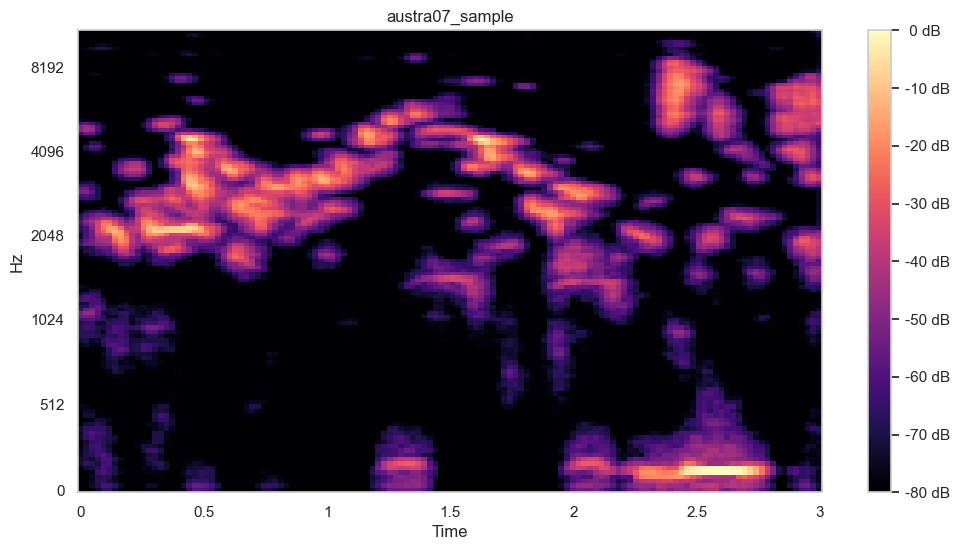

In [28]:
# Visual representation of sample 3 as mel-spectrogram. 
sample3 = librosa.feature.melspectrogram(y=bird_noise_wuw, 
                                       sr=sr, 
                                       n_fft=2048, 
                                       hop_length=512, 
                                       n_mels=128)
# mel_spectrogram is taken in by M_db
M_db2 = librosa.power_to_db(sample3, ref=np.max)
plt.figure(figsize=(12,6)) # Image display only
image3 = librosa.display.specshow(M_db2,        
                                 x_axis='time',
                                 y_axis='mel', 
                                 sr=sr)
plt.title("austra07_sample")
plt.colorbar(image3, format="%2.f dB")
ipd.Audio(data=bird_noise_wuw, rate=sr)

- ### Mixture of Background Bird and Target Bird noise
```

```

Here we got an audio samples that contains the targeted bird and the background bird noise. Using previous example with just the background bird noise (Austra_05_sample), we will add it as noise.

In [29]:
# Add noise to this audio data
snr = 20 # Signal-to-noise
sample_snr = reduced_noise/snr
combined_sample = bird_noise_wuw+sample_snr

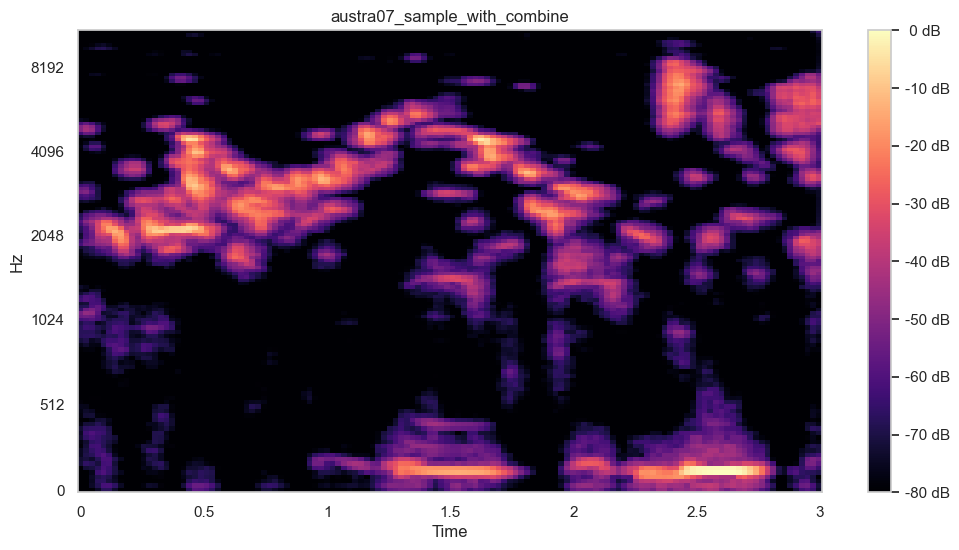

In [30]:
sample4 = librosa.feature.melspectrogram(y=combined_sample, 
                                         sr=sr, 
                                         n_fft=2048, 
                                         hop_length=512, 
                                         n_mels=128)
# mel_spectrogram is taken in by M_db
M_db2 = librosa.power_to_db(sample4, ref=np.max)
plt.figure(figsize=(12,6)) # Image display only
image3 = librosa.display.specshow(M_db2,        
                                 x_axis='time',
                                 y_axis='mel', 
                                 sr=sr)
plt.title("austra07_sample_with_combine")
plt.colorbar(image3, format="%2.f dB")
ipd.Audio(data=combined_sample, rate=sr)

### Combined Audio Clip 
```
```
The combined audio clip of background bird and target bird noise, 20dB for signal to noise. However, there is still the background bird we need to filter out.

## 2.2. Butterworth filter

Further transformation will be done with a fourth order high pass Butterworth filter.
Most common bird frequency (average) will be used for the Butterworth filter value.

In [45]:
def extract_mel_spectrogram(dataset_path):
    y, sr=librosa.load(dataset_path, sr=22050)
    get_bird_mel = librosa.feature.melspectrogram(y=y, 
                                                  sr=sr, 
                                                  n_fft=2048, 
                                                  hop_length=512, 
                                                  n_mels=128)
    return get_bird_mel

In [46]:
# list of mel-spectrogram
mel_spectrogram_counts=[]

for folder in tqdm(folders, desc='Progression'):
    folder_path = os.path.join(dataset_path, folder)
    wav_files = librosa.util.find_files(folder_path, ext='wav')
    
    for wav_file in wav_files:
        get_bird_mel = extract_mel_spectrogram(wav_file)
        mel_spectrogram_counts.append(mel_spectrogram)


Progression: 100%|█████████████████████████████████████████████████████████████████████| 46/46 [02:52<00:00,  3.75s/it]


In [48]:
def mel_calculate_statistics(mel_counts):
    mel_count_values=(mel.shape[1] for mel in mel_counts)
    mel_sum_count=sum(mel_count_values)
    mel_mean_count=sum(mel_count_values)/len(mel_count_values)
    mel_max_count=max(mel_count_values)
    mel_min_count=min(mel_count_values)
    return mel_sum_count, mel_mean_count, mel_max_count, mel_min_count

mel_count_values, mel_counts, mel_max_count, mel_min_count = mel_calculate_statistics(mel_spectrogram_counts)

print(f"Sum Count: {mel_sum_count}")
print(f"Mean Count: {mel_mean_count}")
print(f"Max Count: {mel_max_count}")
print(f"Min Count: {mel_min_count}")

AttributeError: 'list' object has no attribute 'shape'

## 3. Mel Filter Banks

In [40]:
#Declare Mel-Spectrogram features. # fft = 2048, sample rate to respective rate, and mel bands = 177 (max)
filter_banks = librosa.filters.mel(n_fft=2048 , sr=22050 , n_mels= 128)

In [41]:
#Num of Mel bands, Number of fft 
filter_banks.shape

(128, 1025)

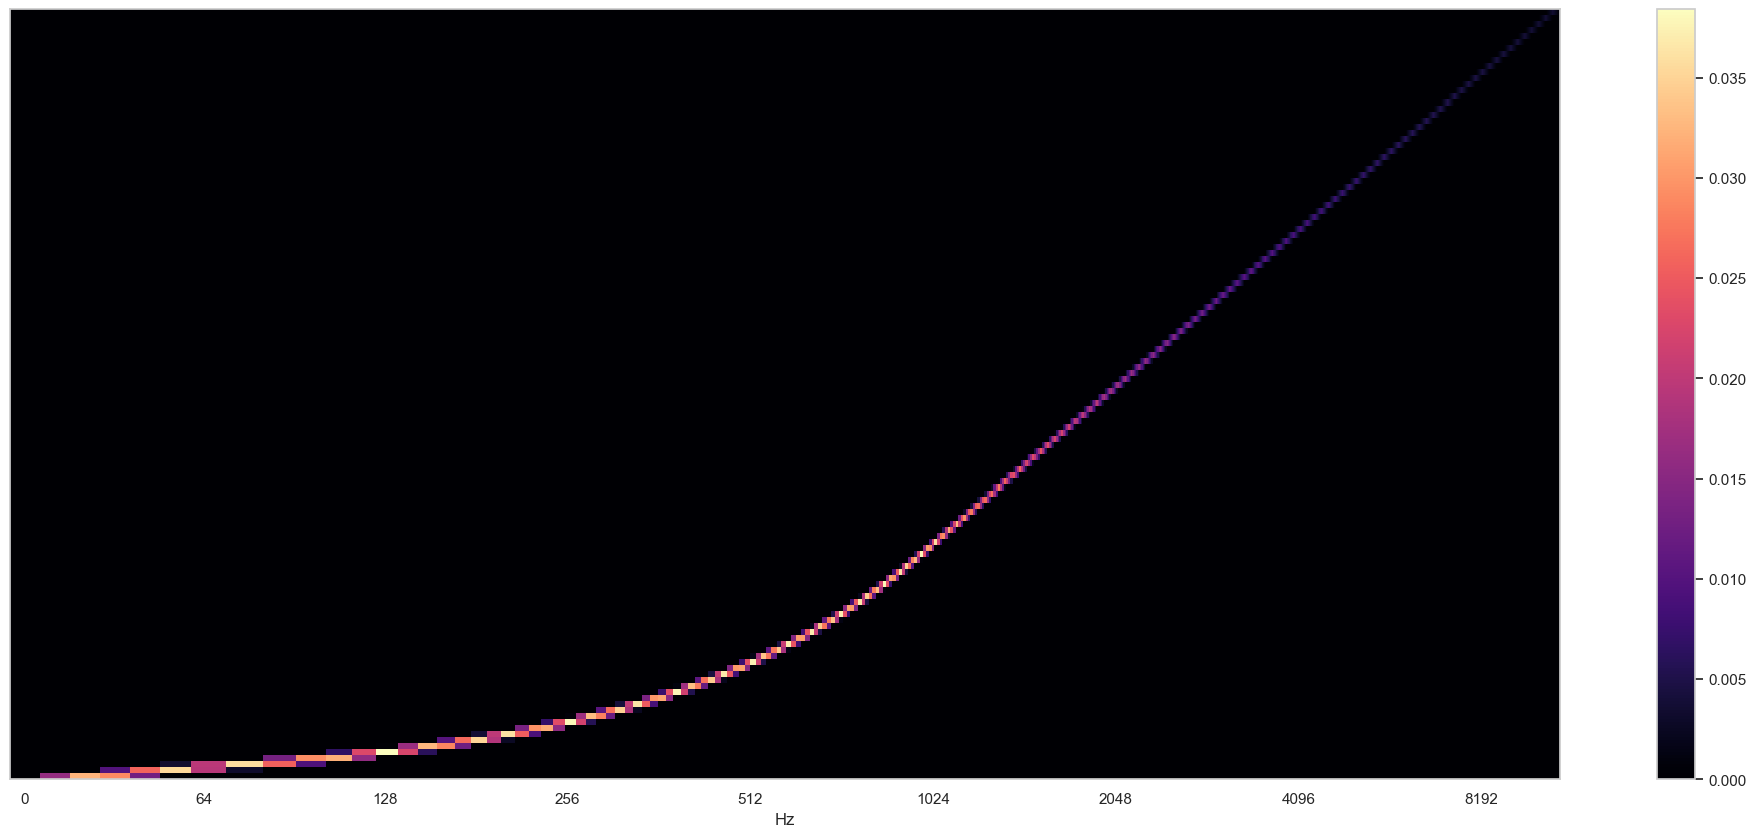

In [42]:
#Visualise Mel-filter banks (log)
plt.figure(figsize=(25,10))
librosa.display.specshow(filter_banks,
                         sr=sr,
                         x_axis='log') #Plot frequency bins logarithmically across x-axis for human preceptual
plt.colorbar()
plt.show()

Each block of pixels represent 'one' mel band that curves vertically. It seems the intensity of the audio dips between 1024 Hz and 2048 Hz, giving us a ground range to work with on our Mel-Spectrogram. Here the plot is plotted logarithmically to precieve human hearing and better present the distance difference between frequency bins. Here, we can set the parameters for our Mel-Spectrogram to visualise the effectiveness of it.

## 3.1. Feature Extracton On Mel-Spectrograms

In [43]:
#177 mel bands will be consitered as it is the cutoff from the audio

# Store Mel-Spectrogram to a list to prevent overlapping
mel_spectrograms = []

# Loop through each folder 
for fold in tqdm(folds, desc = "[OVERALL PROGRESSION]: "):
    folder_path = os.path.join(dataset_path, fold)
    wav_files = librosa.util.find_files(folder_path, ext='wav')
    
    # Loop through each WAV file in the folder
    # "foldes" from Data visualisation
    for wav_file in tqdm(wav_files, desc = (f"Processing wav at {fold}")):
        bird_folder, bird_name, bird_num = os.path.basename(folder_path), os.path.basename(wav_file).split('.')[0], os.path.basename(wav_file).split('.')[1] 
        bird, sr = librosa.load(wav_file)
        mel_spectrogram = librosa.feature.melspectrogram(y=bird, 
                                                         sr=sr,
                                                         n_fft=2048, 
                                                         hop_length=512, 
                                                         n_mels= 128)
        # mel_spectrogram is taken in by M_db
        M_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        # Store mel_spectrogram, subfolders, bird names, and numbers to list
        mel_spectrograms.append([mel_spectrogram, M_db, bird_folder, bird_name, bird_num]) 

[OVERALL PROGRESSION]: 100%|███████████████████████████████████████████████████████████| 46/46 [01:36<00:00,  2.09s/it]


- 177 mel bands as it is the cutoff from the audio. Iterations will help find optimal mel bands
- Tweaked to Mel-Spectrogram features will be required later
- A faster approach should be investigated (Threaded / multiprocessing)

In [47]:
#Check dimensionals (Number of mel bands [y-axis], Number of time frames we extracted [x-axis])
mel_spectrogram.shape

(128, 130)

This shows us the shape of our Mel-Spectrogram; number of Mel bands (Rows), seperated by time frame (Columns)

## 4. Stratified K-Cross Validation 

The reason why stratified k-cross validation is used here is due to how imbalance our dataset is. by applying this technique, each fold for the cross validation will ensure a distributed representation of all the classes in our dataset. It is not guarenteed equal distribution of classes in each fold however, where filtering and upsampling will come later.

In [39]:
# Declare fold directory
folds = os.listdir(dataset_path)

In [40]:
# Assign parameters for stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [48]:
# Extract features of mel-spectrograms (With noise reduced)


In [43]:
# Iterate through each fold to partition train and val
# your_dataset = audio features (mel-spec)
# your_labels = Name of bird species
for fold, (train_idx, val_idx) in enumerate(stratified_kfold.split(your_dataset, your_labels)):
    train_data = your_dataset[train_idx]
    val_data = your_dataset[val_idx]

NameError: name 'your_dataset' is not defined

## 5. Class Balancing

In [ ]:
#Utilise imblearn modules for Synthetic Minority Over-sampling and Random under and over stampler

# Assuming you have X_resampled and y_resampled as shown in the previous response

# Apply SMOTE for oversampling
smote = SMOTE(sampling_strategy='auto')
X_resampled, y_resampled = smote.fit_resample(X_resampled, y_resampled)

# Apply RandomUnderSampler for undersampling (optional)
undersampler = RandomUnderSampler(sampling_strategy='majority')
X_resampled, y_resampled = undersampler.fit_resample(X_resampled, y_resampled)

# Print the class distribution after resampling
print("Class distribution after resampling:", Counter(y_resampled))

## 2.4 Mel-Spectrogram Visualisation

#Loop through Mel-Spectrograms. Unfortunately, the number ordering is based on index postioning over value.

#Iterate through Mel-Spectrogram and subfolders
for mel_spectrogram, M_db, bird_folder, bird_name, bird_num in tqdm(mel_spectrograms, desc="[OVERALL PROGRESSION]: "):
    plt.figure(figsize=(12,4))
    image = librosa.display.specshow(M_db,        
                                     x_axis="time",
                                     y_axis="mel",
                                     sr=sr)
    plt.title(f"{bird_name} / {bird_num} ({bird_folder})")
    plt.colorbar(format="%2.f dB") 
    plt.show()
    plt.close()

Mel-Spectrogram is obtained by converting the audio signal into small segments to perform Fourier transformation (FFT) on each time frame. After that, the frequency reults are mapped on to a matrix for digital representation. Each elements corresponds to the sound energy of a specific frequency bin within a time frame. The colour intensity is represented by the loundness of the sound energy. Mel-Spectrogram visualisation is crucial for analysing bird species based on call. 

- Row = Mel Scale (or Frequency Bins) 
- Columns = Time frame of audio signal

This matrix can be visualised like this:

```
[[n1 n2 n3 ... n]
 [m1 m2 m3 ... m]
 [b1 b1 b3 ... b]
 ... ... ... ...
 [v1 v2 v3 ... v]]
 ```
 
 - Double bracket encapsulates the while matrix
 - The ROW of element (i.e [n1 n2 n3 ...]) represent value of Mel-scaled frequency bins arcoss the time frame
 - The element VALUE (i.e n1, n2, n3, etc) represent magnitude (loudness) of the frequency bins. 
 
Mel-Spectrogram reduces the frequency range which makes processing much easier. 
Our first model took in these 1 dimensional array matrixes as input for the CNN model.
We will be directing in using 2D representation of Mel-Spectrogram array as the input for our CNN model.

git commit yourfile.ipynb
git status
git push origin main